# Brief introduction of data set and data modeling problem

## Objective:
Our datasets contains 30,000 entires with 25 variables. The aim of this project is to identify potential customers that may default through creating different machine learning models. 

In [2]:
%matplotlib inline
#Python
import math, time, random, datetime

#Data Manipulations
import numpy as np
import pandas as pd
import seaborn as sns


#Visuals
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib.legend_handler import HandlerLine2D


In [3]:
#Import train & test data
card = pd.read_csv('card.csv', header= 1)

Each variables from csv file and its respective description: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: 
        -1 = pay duly; 
        1 = payment delay for one month; 
        2 = payment delay for two months; . . .; 
        8 = payment delay for eight months; 
        9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005; 
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - X23 = amount paid in April, 2005. 

# Exploratory Data Analysis

To build a cohesive model, we have to analysis each variables and understand its impact on one another

In [4]:
#Rough data 
card.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
card.shape

(30000, 25)

In [6]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [7]:
#Renaming columns to make it easier to call
card = card.rename(columns={"default payment next month": "Defaulted"})

0    23364
1     6636
Name: Defaulted, dtype: int64
0.7788


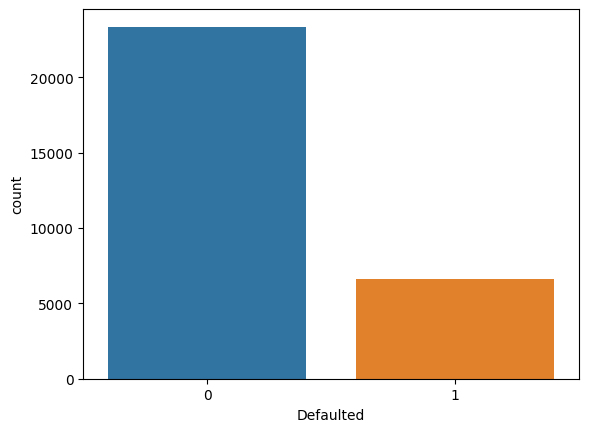

In [8]:
sns.countplot(x = 'Defaulted', data = card)
print(card['Defaulted'].value_counts())
print(23364/30000)

Based on our visualisation, we can see there is a strong majority of card holders who do not default (78%). 
Thus our model should take into account this imbalanced dataset.

### Limit Balance
Reviewing the variable of the amount of the given credit

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

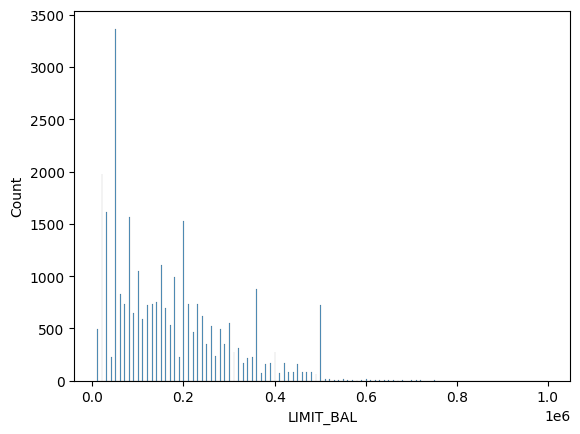

In [9]:
sns.histplot(data = card, x="LIMIT_BAL", binwidth = 2000)
card.LIMIT_BAL.describe()


The mean amount of the amount of given credit is 167,484 and 50% percentile is 140,000. The graph is right skewed and a good estimate of the rough amount of given credit can be determined by the 1IQR to 3IQR which is 50,000 to 240,000.

Generally, the amount of credit can be pereceived as a potential factor in determing whether one defaults as the higher spending power means users can save more and avoid defaulting with the spare income. We will be considering this variable in our model

### Sex
Reviewing the variable of Sex and its demographic: 
  - 1 represents Male
  - 2 represents Female

In [10]:
card['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

<AxesSubplot:xlabel='SEX', ylabel='count'>

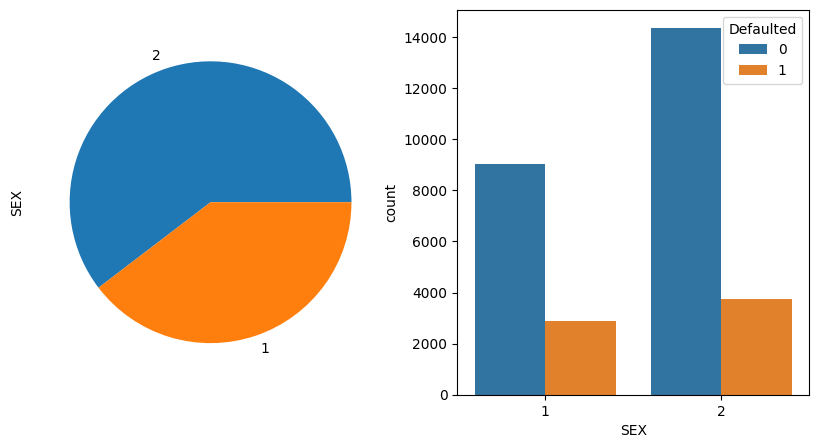

In [11]:
fig, axes = plt.subplots(ncols=2,figsize=(10,5))
card["SEX"].value_counts().plot(kind="pie",ax=axes[0],subplots=True)
sns.countplot(x = "SEX", hue = 'Defaulted',ax=axes[1], data = card)

There are more females than males and thus, a higher number of default lies on females. 
However, males appear to have a higher proportion of default.

Generally, gender can be perceived as a potential factor in determing whether one defaults due to societal gender roles and standings which may influence income and financial situation. We will be considering this variable in our model

### Education
Reviewing the variable of Education and its demographic: 
  - 1 represents Graduate School
  - 2 represents University
  - 3 represents Highschool
  - 4 represents Others

In [12]:
card['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [13]:
card['EDUCATION'] = card['EDUCATION'].replace([5, 6, 0], 4)
#replaced values that are not 1-4 with 4 (Others)
card['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

<AxesSubplot:xlabel='EDUCATION', ylabel='count'>

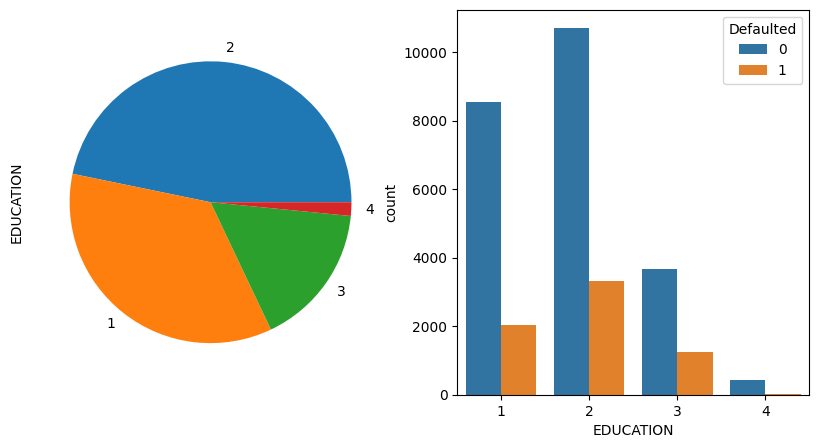

In [14]:
fig, axes = plt.subplots(ncols=2,figsize=(10,5))
card["EDUCATION"].value_counts().plot(kind="pie",ax=axes[0],subplots=True)
sns.countplot(x = "EDUCATION", hue = 'Defaulted',ax=axes[1], data = card)

Majority of participants University or Graduate school education and thus generally majority of the defaulters lies among them.

Generally, education level can be perceived as a potential factor in determing whether one defaults due to the different pay scale certain education level holds as well as their debt from schooling, which will likely influence their financial situation. We will be considering this variable in our model.

### Marriage
Reviewing the variable of Marriage and its demographic: 
  - 1 represents Single
  - 2 represents Married
  - 3 represents Others

In [15]:
card['MARRIAGE'].value_counts() 

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [16]:
card['MARRIAGE'] = card['MARRIAGE'].replace([0], 3)
#replaced values that are not 1-4 with 4 (Others)
card['MARRIAGE'].value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

<AxesSubplot:xlabel='MARRIAGE', ylabel='count'>

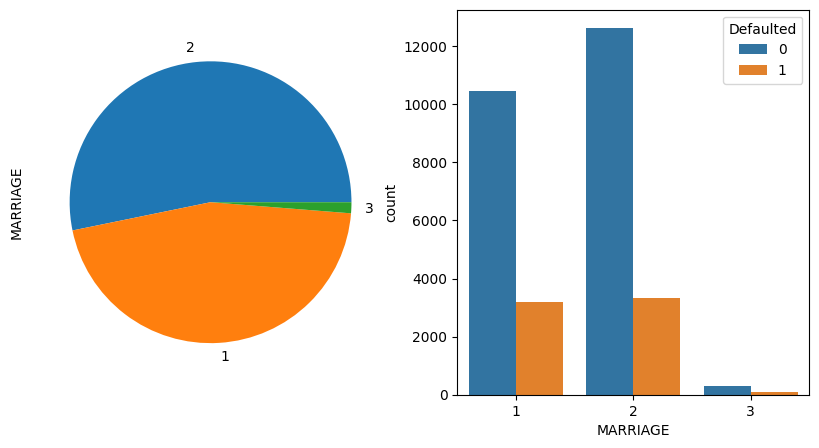

In [17]:
fig, axes = plt.subplots(ncols=2,figsize=(10,5))
card["MARRIAGE"].value_counts().plot(kind="pie",ax=axes[0],subplots=True)
sns.countplot(x = "MARRIAGE", hue = 'Defaulted',ax=axes[1], data = card)

There are more married than unmarried participants. However, the number of people who defaulted seems to be split evenly, suggesting a higher rate of default amongst single.

Generally, marriage can be perceived as a potential factor in determing whether one defaults due to the combined pool of financial responsibilities and financial burden from sustaining a family, which will likely influence their financial situation. We will be considering this variable in our model.

Reviewing our datasets, we find there are several categorical variables such as marriage, sex and education which may be instrumental in predicting defaulters and definitely should be included in our model

### Age 
Reviewing the variable of age and its demographic

<AxesSubplot:xlabel='AGE', ylabel='Count'>

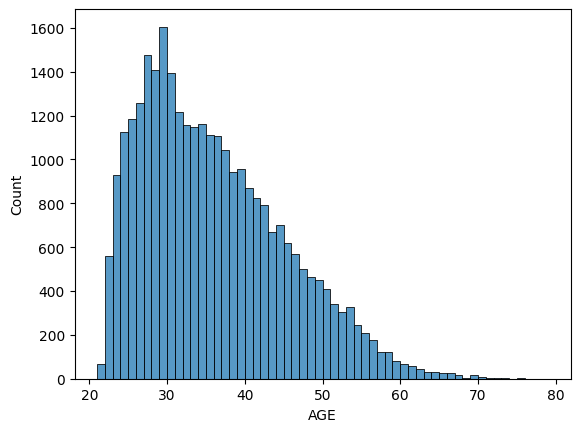

In [18]:
sns.histplot(data = card, x="AGE", binwidth = 1)

Generally, a large proportion of our participants lies within the ages of 25 - 40 years old.

Generally, age can be perceived as a potential factor in determing whether one defaults due to the different spending habits that comes with age, which will likely influence their financial situation. We will be considering this variable in our model.

### History of past payment 
We will review the variables of each past payments and attempt to draw any links within 

In [19]:
pay = card[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
pd.concat([pay['PAY_0'],pay['PAY_2'],pay['PAY_3'],pay['PAY_4'],pay['PAY_5'],pay['PAY_6']]).unique()

array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6])

In [20]:
card['PAY_0'] = card['PAY_0'].replace([-2], 1)
card['PAY_2'] = card['PAY_2'].replace([-2], 1)
card['PAY_3'] = card['PAY_3'].replace([-2], 1)
card['PAY_4'] = card['PAY_4'].replace([-2], 1)
card['PAY_5'] = card['PAY_5'].replace([-2], 1)
card['PAY_6'] = card['PAY_6'].replace([-2], 1)
pd.concat([card['PAY_0'],card['PAY_2'],card['PAY_3'],card['PAY_4'],card['PAY_5'],card['PAY_6']]).unique()


array([ 2, -1,  0,  1,  3,  4,  8,  7,  5,  6])

In [21]:
def drawhist(df, variables, binval):
    fig=plt.figure()
    for i, name in enumerate(variables):
        ax=fig.add_subplot(2,3,i+1)
        df[name].hist(bins=binval,ax=ax)
        ax.set_title(name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


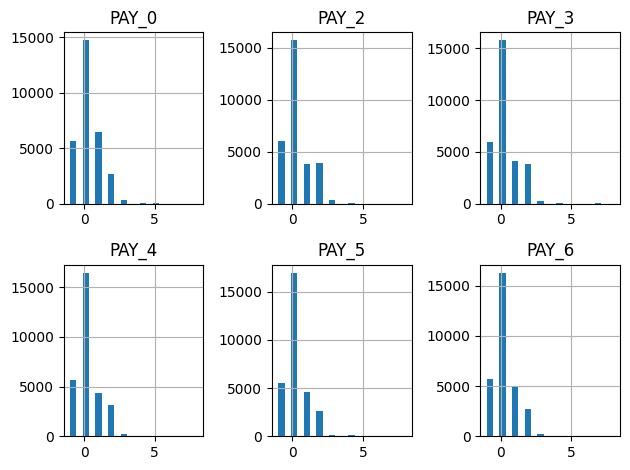

In [22]:
drawhist(card[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']], ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],20)

Generally, we see a consistent trend in payment status across different months.

Past payment can be perceived as a potential factor in determing whether one defaults as the amount paid the previous year suggests the spending habits of the target, which would be correlated to their financial situation. We will be considering this variable in our model.

### Amount of bill statement (NT dollar)
We will review the variables of the cost of each bill payments across the months and attempt to draw any links within 

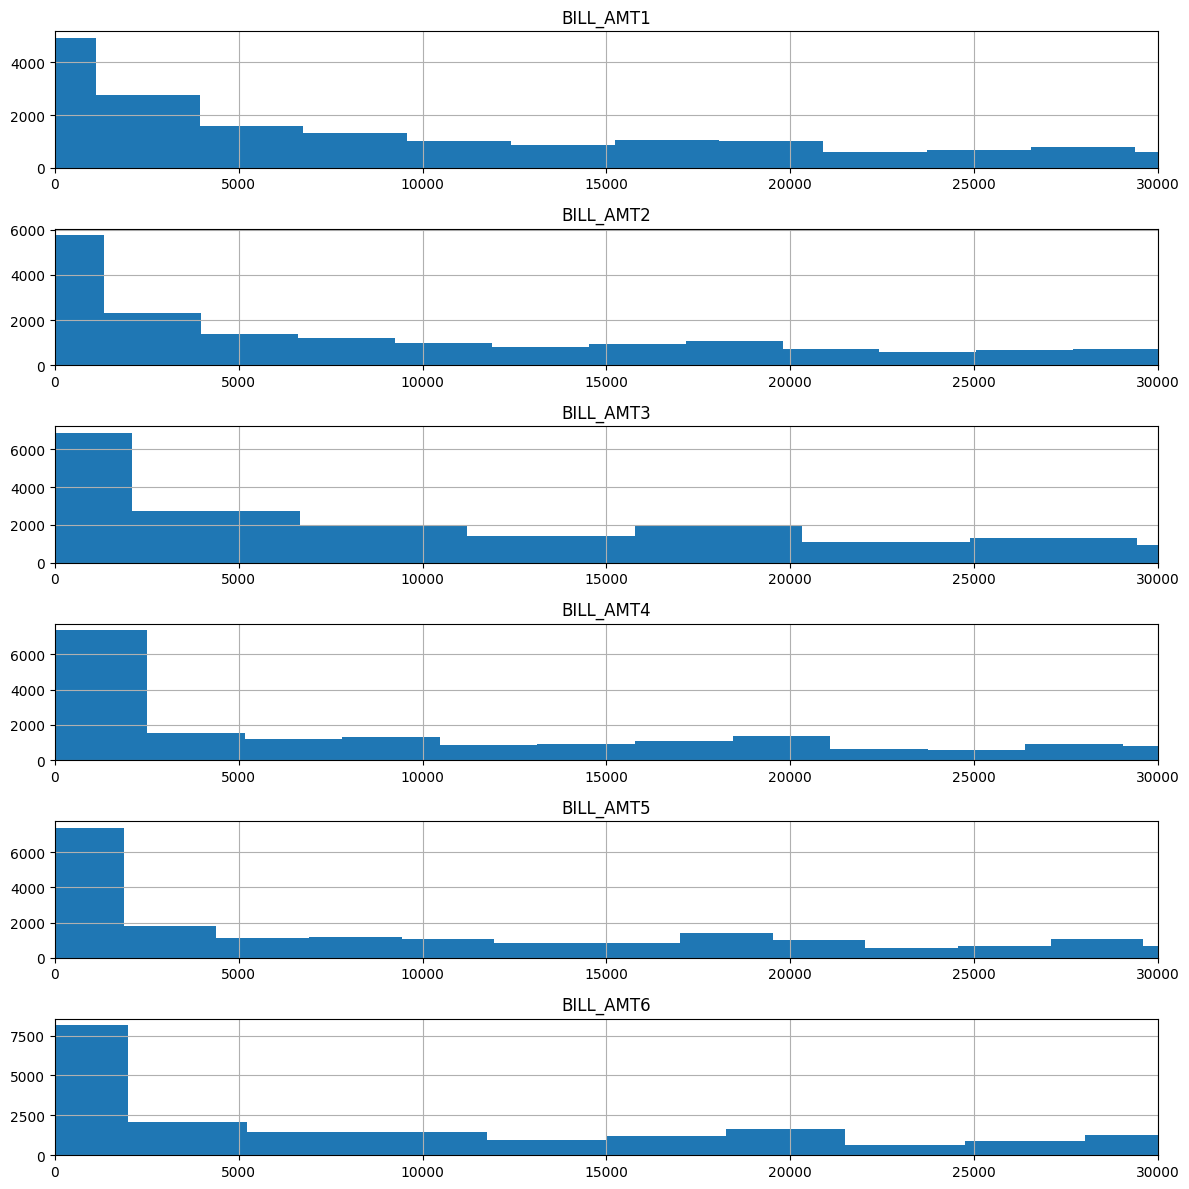

In [23]:
def drawhist(df, variables, binval):
    fig = plt.figure(figsize = (12,12))
    for i, name in enumerate(variables):
        ax=fig.add_subplot(6,1,i+1)
        df[name].hist(bins=binval,ax=ax)
        plt.xlim(0, 30000) #arbitrary ylim of 30,000 for easier visualisation of histogram of payment amount 
        ax.set_title(name)
    fig.tight_layout() 
    plt.show()


drawhist(card[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']], 
['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'],400)


Generally, we see a consistent trend in the bill amount across different months 

Generally, bill amount across different months can be perceived as a potential factor in determing whether one defaults as the amount spent by the user will likely be correlated to their financial situation. We will be considering this variable in our model.

### Amount of bill statement paid (NT dollar)
We will review the variables of how much each bill payments was paid across the months and attempt to draw any links within 

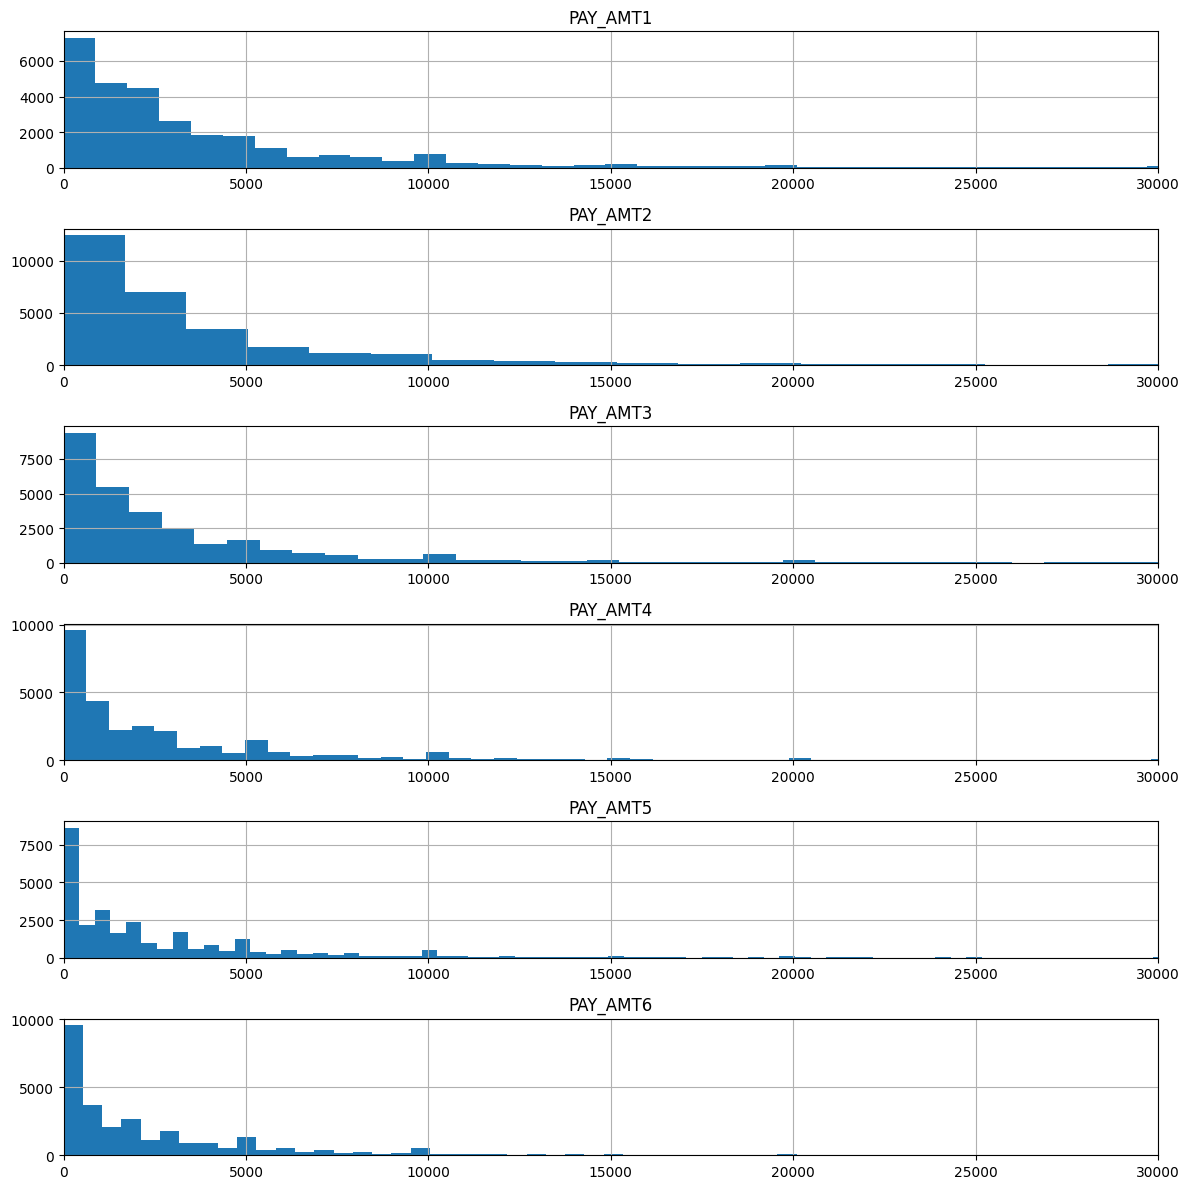

In [24]:

def drawhist1(df, variables, binval):
    fig = plt.figure(figsize = (12,12))
    for i, name in enumerate(variables):
        ax=fig.add_subplot(6,1,i+1)
        df[name].hist(bins=binval,ax=ax)
        plt.xlim(0, 30000) #arbitrary ylim of 30,000 for easier visualisation of histogram of payment amount 
        ax.set_title(name)
    fig.tight_layout() 
    plt.show()

drawhist1(card[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']], 
['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],1000)

Generally, bill amount paid across different months can be perceived as a potential factor in determing whether one defaults as the amount that the user has paid suggest the level of wealth the user has and will likely be correlated to their financial situation. We will be considering this variable in our model.

After processing our data and selecting relevant features, we will proceed with the construction of our model 

# Feature Selection
We will be using everything lmao
can include corrplot as well

In [25]:
card1 = pd.get_dummies(card,prefix=['MARRIAGE','EDUCATION','SEX'],columns = ['MARRIAGE','EDUCATION','SEX'], drop_first=True)
card1.drop(columns = "ID")

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,Defaulted,MARRIAGE_2,MARRIAGE_3,EDUCATION_2,EDUCATION_3,EDUCATION_4,SEX_2
0,20000,24,2,2,-1,-1,1,1,3913,3102,...,0,0,0,1,0,0,1,0,0,1
1,120000,26,-1,2,0,0,0,2,2682,1725,...,1000,0,2000,1,1,0,1,0,0,1
2,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,5000,0,1,0,1,0,0,1
3,50000,37,0,0,0,0,0,0,46990,48233,...,1100,1069,1000,0,0,0,1,0,0,1
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,9000,689,679,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,0,0,0,0,0,0,188948,192815,...,3047,5000,1000,0,0,0,0,1,0,0
29996,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,129,0,0,0,1,0,0,1,0,0
29997,30000,37,4,3,2,-1,0,0,3565,3356,...,4200,2000,3100,1,1,0,1,0,0,0
29998,80000,41,1,-1,0,0,0,-1,-1645,78379,...,1926,52964,1804,1,0,0,0,1,0,0


In [26]:
corr = card1.corr()
corr.style.background_gradient(cmap='coolwarm')

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Defaulted,MARRIAGE_2,MARRIAGE_3,EDUCATION_2,EDUCATION_3,EDUCATION_4,SEX_2
ID,1.000000,0.026179,0.018678,0.013830,0.011996,0.006229,0.024862,0.006049,0.009643,0.019389,0.017982,0.024354,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952,-0.023794,-0.012724,0.002569,0.017475,0.037165,0.018497
LIMIT_BAL,0.026179,1.000000,0.144713,-0.133950,-0.157767,-0.157154,-0.143385,-0.129486,-0.136309,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520,-0.090998,-0.056001,-0.147530,-0.139686,0.013420,0.024755
AGE,0.018678,0.144713,1.000000,0.000082,-0.006737,-0.008772,-0.002124,-0.004484,-0.014719,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890,-0.466584,0.080767,-0.077626,0.231252,0.008982,-0.090874
PAY_0,0.013830,-0.133950,0.000082,1.000000,0.715566,0.545241,0.499465,0.463922,0.416383,0.053422,0.058481,0.058331,0.059507,0.067551,0.067952,-0.078727,-0.053579,-0.067035,-0.050967,-0.044182,-0.046095,0.318908,-0.008000,0.003519,0.050524,0.037973,-0.004012,-0.020151
PAY_2,0.011996,-0.157767,-0.006737,0.715566,1.000000,0.654208,0.529295,0.483852,0.432130,0.048976,0.047305,0.047768,0.049478,0.057804,0.060600,-0.139381,-0.067916,-0.078275,-0.054430,-0.050825,-0.054969,0.278614,-0.005252,0.001441,0.058978,0.035794,-0.020148,-0.029396
PAY_3,0.006229,-0.157154,-0.008772,0.545241,0.654208,1.000000,0.670224,0.552337,0.496768,0.014719,0.028230,0.020895,0.028175,0.036811,0.040909,-0.057075,-0.121702,-0.083394,-0.061767,-0.056365,-0.058197,0.247124,0.000531,0.004100,0.046499,0.035299,-0.029802,-0.024659
PAY_4,0.024862,-0.143385,-0.002124,0.499465,0.529295,0.670224,1.000000,0.721797,0.586417,-0.001106,0.006126,0.017013,0.018385,0.026373,0.031471,-0.065525,-0.053268,-0.141310,-0.079761,-0.063477,-0.053906,0.230826,-0.002586,0.003488,0.038603,0.031580,-0.024819,-0.027727
PAY_5,0.006049,-0.129486,-0.004484,0.463922,0.483852,0.552337,0.721797,1.000000,0.713699,-0.000989,0.004261,0.012943,0.026776,0.027324,0.031905,-0.061458,-0.043559,-0.058094,-0.143477,-0.069666,-0.056351,0.220109,-0.002271,-0.006122,0.034177,0.018555,-0.018561,-0.025671
PAY_6,0.009643,-0.136309,-0.014719,0.416383,0.432130,0.496768,0.586417,0.713699,1.000000,-0.005649,-0.000991,0.003259,0.016622,0.033221,0.030532,-0.062022,-0.057229,-0.059237,-0.056743,-0.142225,-0.074089,0.203131,0.005827,-0.004405,0.035746,0.015514,-0.013160,-0.026791
BILL_AMT1,0.019389,0.285430,0.056239,0.053422,0.048976,0.014719,-0.001106,-0.000989,-0.005649,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341,-0.019644,-0.021347,-0.017327,0.030323,-0.022006,0.036364,-0.033642


Generally, we from our above analysis as well we do not see a strong correlation in the Default row and after carefully reviewing each variable above, we have decided to include all potentially relevant variables into our model. (All apart from id which does not have a clear link to default)

# Model Selection and Evaluation
We will be going through random models and evaluating their success rate

We are going to use the following models:
1. Log Regression
2. SVM
3. Neural Network 
4. Random Forest
5. XGBoost 

We will explain the following selections as we touch on each model

For our evaluation metrics we will be touching on the following scores:
 1. Accuracy
 2. Precision
 3. Recall
 4. F1 Score
 5. ROC Score

The reason for choosing these metrics is as follows:

In [27]:
#Copying datasets and splitting into train-test
X = card1.copy().drop("Defaulted", axis = 1)
Y = card1["Defaulted"]
X_base_train, X_base_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 40)

We have chosen a train to test ratio of 4 : 1 and defined a random state of splitting to avoid bias 

## Log Regression

Our dependent variable is binary and can be used to predict binary values. It is a simple yet commonly used model, and is apt in this classification scenario 

In [28]:
# Log reression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

rf_model = LogisticRegression(class_weight = 'balanced') #balanced weights of dfiferent size samples

rf_model.fit(X_base_train, Y_train)
pred_rf = rf_model.predict(X_base_test)

LR_test_accuracy_SVC = accuracy_score(pred_rf,Y_test)
LR_test_precision_score_SVC = precision_score(pred_rf,Y_test)
LR_test_recall_score_SVC = recall_score(pred_rf,Y_test)
LR_test_f1_score_SVC = f1_score(pred_rf,Y_test)
LR_test_roc_score_SVC = roc_auc_score(pred_rf,Y_test)



print("The accuracy on test data is ", LR_test_accuracy_SVC)
print("The precision on test data is ", LR_test_precision_score_SVC)
print("The recall on test data is ", LR_test_recall_score_SVC)
print("The f1 on test data is ", LR_test_f1_score_SVC)
print("The roc_score on test data is ", LR_test_roc_score_SVC)



The accuracy on test data is  0.5956666666666667
The precision on test data is  0.6529992406985573
The recall on test data is  0.303994344291269
The f1 on test data is  0.4148576941630487
The roc_score on test data is  0.5799378848545591


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## SVM
SVM model are effective in classification problems and are effective in higher dimensions and versatile for different kernel types. It has higher performance and can be easily tuned

In [29]:
#SVM 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


clf = make_pipeline(StandardScaler(), SVC(kernel='poly',class_weight="balanced"))
clf.fit(X_base_train,Y_train)
pred_rf = clf.predict(X_base_test)


SVM_test_accuracy_SVC = accuracy_score(pred_rf,Y_test)
SVM_test_precision_score_SVC = precision_score(pred_rf,Y_test)
SVM_test_recall_score_SVC = recall_score(pred_rf,Y_test)
SVM_test_f1_score_SVC = f1_score(pred_rf,Y_test)
SVM_test_roc_score_SVC = roc_auc_score(pred_rf,Y_test)

print("The accuracy on test data is ", SVM_test_accuracy_SVC)
print("The precision on test data is ", SVM_test_precision_score_SVC)
print("The recall on test data is ", SVM_test_recall_score_SVC)
print("The f1 on test data is ", SVM_test_f1_score_SVC)
print("The roc_score on test data is ", SVM_test_roc_score_SVC)

The accuracy on test data is  0.7631666666666667
The precision on test data is  0.5793470007593015
The recall on test data is  0.46809815950920247
The f1 on test data is  0.517814726840855
The roc_score on test data is  0.670662352065814


## Neural Network
Neural networks are effective in classifications as it allows for easy interpretation of complex nonlinear relationships between variables and availability of multiple training algorithms. Unseen relationships between variables can be created, improving the results of the model. 

In [30]:
#NN
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier( solver='adam', alpha=1e-5,  hidden_layer_sizes=(12),random_state=40, max_iter=1000) 
clf.fit(X_base_train,Y_train)
pred_rf = clf.predict(X_base_test)

NN_test_accuracy_SVC = accuracy_score(pred_rf,Y_test)
NN_test_precision_score_SVC = precision_score(pred_rf,Y_test)
NN_test_recall_score_SVC = recall_score(pred_rf,Y_test)
NN_test_f1_score_SVC = f1_score(pred_rf,Y_test)
NN_test_roc_score_SVC = roc_auc_score(pred_rf,Y_test)

print("The accuracy on test data is ", NN_test_accuracy_SVC)
print("The precision on test data is ", NN_test_precision_score_SVC)
print("The recall on test data is ", NN_test_recall_score_SVC)
print("The f1 on test data is ", NN_test_f1_score_SVC)
print("The roc_score on test data is ", NN_test_roc_score_SVC)

The accuracy on test data is  0.7843333333333333
The precision on test data is  0.2741078208048595
The recall on test data is  0.5164520743919886
The f1 on test data is  0.3581349206349206
The roc_score on test data is  0.668054371472546


## Random Forest
Random forest focuses on the best features of the model and does not require much normalization or scaling. This allows for 

In [35]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 40, class_weight="balanced")

rf_model.fit(X_base_train, Y_train)
pred_rf = rf_model.predict(X_base_test)

RF_test_accuracy_SVC = accuracy_score(pred_rf,Y_test)
RF_test_precision_score_SVC = precision_score(pred_rf,Y_test)
RF_test_recall_score_SVC = recall_score(pred_rf,Y_test)
RF_test_f1_score_SVC = f1_score(pred_rf,Y_test)
RF_test_roc_score_SVC = roc_auc_score(pred_rf,Y_test)

print("The accuracy on test data is ", RF_test_accuracy_SVC)
print("The precision on test data is ", RF_test_precision_score_SVC)
print("The recall on test data is ", RF_test_recall_score_SVC)
print("The f1 on test data is ", RF_test_f1_score_SVC)
print("The roc_score on test data is ", RF_test_roc_score_SVC)

The accuracy on test data is  0.8183333333333334
The precision on test data is  0.3675018982536067
The recall on test data is  0.6531713900134952
The f1 on test data is  0.4703595724003887
The roc_score on test data is  0.7473881289295466


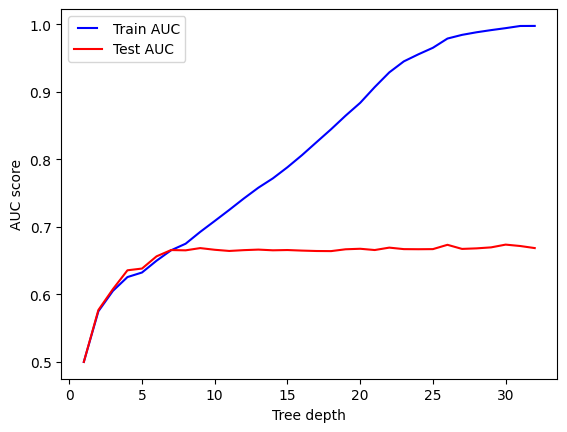

In [53]:
# Tuning for max depth 
max_depths = np.linspace(1, 28,28,dtype= int, endpoint=True)
trainresult = []
testresult = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_base_train, Y_train)
   train_pred = rf.predict(X_base_train)
   FPR2, TPR, TH = roc_curve(Y_train, train_pred)
   trainresult.append(auc(FPR2, TPR))
   y_pred = rf.predict(X_base_test)
   FPR2, TPR2, TH = roc_curve(Y_test, y_pred)
   testresult.append(auc(FPR2, TPR2))
line1, = plt.plot(max_depths, trainresult, "b", label="Train AUC")
line2, = plt.plot(max_depths, testresult, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

In [54]:
#Improved Model for Random Forest 
rf_model = RandomForestClassifier(random_state = 40, class_weight="balanced", max_depth= 9)

rf_model.fit(X_base_train, Y_train)
pred_rf = rf_model.predict(X_base_test)

RF_test_accuracy_SVC = accuracy_score(pred_rf,Y_test)
RF_test_precision_score_SVC = precision_score(pred_rf,Y_test)
RF_test_recall_score_SVC = recall_score(pred_rf,Y_test)
RF_test_f1_score_SVC = f1_score(pred_rf,Y_test)
RF_test_roc_score_SVC = roc_auc_score(pred_rf,Y_test)

print("The accuracy on test data is ", RF_test_accuracy_SVC)
print("The precision on test data is ", RF_test_precision_score_SVC)
print("The recall on test data is ", RF_test_recall_score_SVC)
print("The f1 on test data is ", RF_test_f1_score_SVC)
print("The roc_score on test data is ", RF_test_roc_score_SVC)

The accuracy on test data is  0.7883333333333333
The precision on test data is  0.5998481397114654
The recall on test data is  0.5153294194390085
The f1 on test data is  0.5543859649122805
The roc_score on test data is  0.6986765745057142


# Conclusion
Across the 4 different models, we see a relatively high accuracy rate for most of them (SVM, Neural Network and Random Forest) of roughly 80% (Log Regression only had 60%). This is a good mark as 80% prediction rate for test sets is a decent score. However, the precision for the 4 models are comparatively dismal as Log Regression, SVM, Neural Network and Random Forest each only acquired 65%, 58% 27%, 60% respectively. This means that our model does not perform as well in high number of false positives. 

While we have already noted balancing class weights in our model (inserting class_weights in our model to increase penalty of the wrong classification of smaller sized class), we still fail to achieve a strong precision and perhaps more could be done in terms of sampling to reduce this disparity. Another issue could be overfitting of the model and more can be done in terms of tuning or performing k-fold cross validation. 

Looking at the f1-score, we see that SVM has the most success with 51% and this model should be preferentially used in determing who may default.